## Description:
######Model type = RNN
######Hidden layers = 1024*2
######train seq_len = 200
######model id = rnn1024-200
######corrected, add cell type param, random test data



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

Google Colab Mounting

In [0]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Hyper Params

In [0]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 1024
n_layers = 2
cell_type = "rnn"
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = True
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "rnn1024-200" #save as 
load_model_name = "rnn1024-200checkpoint_ep_291.207.cp"
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Data Loading

In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Data Preprocessing

In [0]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [0]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 1024])
test forwardc
torch.Size([67]) torch.Size([2, 1, 1024])
test cal_accuracy
0.0064500002190470695
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
hRhYVLgBWEVFOkUzxf3rOFPHlzVjOF,vHOk,lUWDH]RA
ERUW$T'[AaFO FOUzpFlpqkYpT']x
$,Q]R3,q]cADg$QF'pyLOz]NHTATLOUYjp.Aj ]$URUPTOc,qkPmzOoL,zOUDCyC:RBMeTli?ATOYEQpBzkRlH?FFE3QFsV;xA&WpeCrFFFU
Ox3pUzdV3vUHlUgm
test generate with forwardc
JulietBdOYiAYMBx$zmzCRwqg'FLfQF&nfjzCVQT$Usp]
mk?TslGwk$ToiA]khTo:eUzSMig$zeHm'?Lz3V?[?:FJ3sTsc,F&fSEWWpXCvo,].hY:ReFhEQ,pR].kH?p&nufF&tQL,]kqWeHzmC.L;p&nl3 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 1024]) torch.Size([2, 50, 1024])
test forwardc
torch.Size([67]) torch.S

Build new model

In [9]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new {}-{} model and record initted".format(cell_type, hidden_size))
model

new rnn-1024 model and record initted


CharRNN(
  (encoder): Embedding(67, 1024)
  (rnn): RNN(1024, 1024, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=1024, out_features=67, bias=True)
)

Or Load saved model

In [15]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load(model_path+load_model_name, map_location=lambda storage, loc: storage)['model'])
    #print(torch.load(model_path+load_model_name)['model'])
    model.eval() #important
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Model parameters loaded from disk.
Records loaded from disk.


Use GPU if available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


Train

In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [0]:
if not LOAD:
    train()

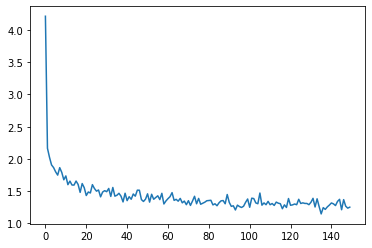

In [0]:
plt.figure()
plt.plot(record['loss'])
plt.show()

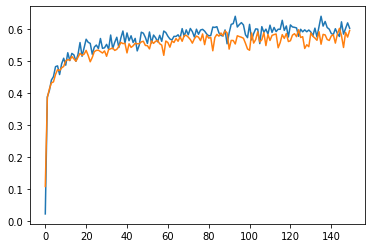

0.6014999747276306
0.5947999954223633
1.2486952543258667


In [16]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

print(record['trainAC'][-1])
print(record['testAC'][-1])
print(record['loss'][-1])

In [0]:
print(model.state_dict())
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
print(calc_accuracy(model, train_data, n_batch=len(train_data)-1, device=device))

OrderedDict([('encoder.weight', tensor([[ 2.4745, -0.6322,  0.8943,  ..., -0.5176, -0.5396, -0.4830],
        [ 0.4109, -0.2684,  1.3165,  ...,  0.0624, -0.0733,  0.2706],
        [-0.0868,  1.3220, -1.1575,  ..., -0.5162,  0.0771, -0.2074],
        ...,
        [ 0.3360, -1.2563, -0.3904,  ..., -0.3054, -0.9912,  0.5874],
        [ 2.1202, -0.2339,  0.9159,  ..., -1.3520,  0.4694,  0.4701],
        [-0.2913,  0.4012,  0.2887,  ...,  0.1715, -1.1286, -0.2160]],
       device='cuda:0')), ('rnn.weight_ih_l0', tensor([[-0.0039,  0.0058,  0.0342,  ...,  0.0162,  0.0223,  0.0043],
        [-0.0206,  0.0303,  0.0325,  ...,  0.0329,  0.0347,  0.0051],
        [-0.0192,  0.0176,  0.0358,  ...,  0.0139, -0.0118, -0.0182],
        ...,
        [ 0.0133, -0.0117,  0.0285,  ..., -0.0398, -0.0280, -0.0110],
        [ 0.0253, -0.0343,  0.0108,  ...,  0.0006, -0.0118,  0.0271],
        [-0.0083,  0.0276,  0.0031,  ..., -0.0285, -0.0252, -0.0188]],
       device='cuda:0')), ('rnn.weight_hh_l0', tensor

In [0]:
print(generate(model, device)) #default tau = 0.8

JulietUwYo!QA&[ !G[ar[Q[T rQ[WQrA!&
RYYoUttUKwYhW3!WiQAWWqQ[WQ[T!QTWA!iQ[T!Q-&zQW'Q&--YT 3Q'WqQ[T!r!Q[ 3!rQ&QEWWbQTWGW,qiYOGbQ[T!QE!G!q&-RQSWbQr&B!QuW,qQT&G


In [0]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

julietUQ$-&[[!qQ[T!Q3&GQ[T&[Qz!QT&B!Qr!!GYtT!Qr[&[!QW'Q[T!QzWq-bQ[WQ[T!Qr[&[!iYOGbQ[T!Qr[qWGEQAqWA!qQr[&[!QW'Q[T!QzWq-biYOGbQ[T!q!'Wq!Qk!Q[T!Q3WqG GEQ[T!QzW 

juliethTQJaQUPJtyOKQgy !cemoLOftgcIecmwYcGG r kWwQo,!iQIQk!Q-W,bxQTGQ'qW3l]iQ&G&qp!r[!bQpT GbiYk,b
3rQpWWAiQfWq[TJ,A[NUGVRYK&r[WqiQ- p[G!Gr.YN&AHz!q&BWG.Q3& 



In [0]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') 

i willwYIQr&uiQK&r[!qQm qQD -- &3RYm qQ;WTGiQ[T!GQ3,r[QuW,Qr!!QuW,QT!q!sYY$OJmtO$$wYm qiQ rQ'Wq[TQ[T!Q&AAqW&pT!rQ,GTW-bQ&Q'& q.YOrQrW-b !qrQAqW3 r!bxQk,[QzT!GQ[TW,Qb br[QGW[QEWQ GY[T!QTWqr!Q[WQT!qQ3& b!GrQ[WQ[T!QmpW[-&GbQ[T!Q
 GEYOGbQA,[Q[T!Q'- ET[QW'QT!qQr[&urYOGbQ&rQ[TW,Qbq!&3rQr[ --Q&zT -!Q GQ[TuQ[!Gb!qG!rrYDT pTQq!Gb!qabQ'WqQ3uQ[!G[iQr&3!Q Gr[q,3!G[YtT&[QEq!&[QAW G[Q&QpW33WGQ[ 3!RYYo?f?dIeMwYtT!q!Qz&rQ[T!Q3&[[!qRYYdUKItIcmQ?fUoOhocmwYf&uiQ&b !,RYYKImth?mmQgcIeMJjwYDT&[iQ&q!QT&bQ[T!QG&[ WGQ'WqQ[T!Q 



In [0]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
!QQYYGQQQQ&u!W     TWAYQ&WQ!hVcU$rw?qIwwwwcwr[wcmw!w&cYYYY&YYYiiiYYYWWb [-YQub&YY!!QQYYGQQQQ&u!W t!QGrQQprQwiQ&YYuiW!W[[QQW&r c&jY&r cmwGwchwcwYYYYwY.wwwYYYYYTiW!YQQ&YYuQW!YQQ!QQYYGQQQQ&u!W  QQQQqGQ&Q


In [0]:
seeds = ["I", "Juliet", "KING:", "my lord", "flower", "soldier", "my son", "father", "hope", "death"]
for seed in seeds:
    print("------------seed: {}-----------".format(seed))
    print(generate(model, device, seed=seed, predict_len=500, tau=0.8))

In [0]:
for name, param in model.named_parameters():
    print(name, ':', param.requires_grad)

encoder.weight : True
rnn.weight_ih_l0 : True
rnn.weight_hh_l0 : True
rnn.bias_ih_l0 : True
rnn.bias_hh_l0 : True
rnn.weight_ih_l1 : True
rnn.weight_hh_l1 : True
rnn.bias_ih_l1 : True
rnn.bias_hh_l1 : True
decoder.weight : True
decoder.bias : True


In [0]:
modelload = torch.load(model_path+"best_model_gpu.pt", map_location=lambda storage, loc:storage.cuda(0))
modelload.eval()
print(modelload.state_dict())

OrderedDict([('encoder.weight', tensor([[ 1.0952,  0.4454,  0.6000,  ...,  0.0213, -0.8545, -0.2778],
        [-1.7291,  0.7577,  0.2283,  ..., -0.5458,  0.9066,  0.1585],
        [ 0.7658,  1.1770,  1.7650,  ...,  0.6609, -1.0342,  0.6628],
        ...,
        [-0.2598,  2.0608, -0.6937,  ...,  1.0235, -1.8630, -0.5853],
        [ 0.0774, -1.0873, -1.0426,  ..., -0.4832, -0.3845, -1.0078],
        [ 1.1430,  0.6575, -1.4067,  ..., -1.1925, -0.7909,  0.5240]],
       device='cuda:0')), ('rnn.weight_ih_l0', tensor([[ 0.0351, -0.0130,  0.0352,  ..., -0.0342,  0.0090,  0.0157],
        [-0.0173,  0.0316, -0.0032,  ...,  0.0233, -0.0079,  0.0114],
        [ 0.0030, -0.0223, -0.0141,  ..., -0.0187,  0.0119,  0.0147],
        ...,
        [-0.0441,  0.0319,  0.0266,  ..., -0.0014,  0.0114,  0.0738],
        [ 0.0189,  0.0183, -0.0151,  ...,  0.0167, -0.0209,  0.0214],
        [-0.0038,  0.0216,  0.0371,  ...,  0.0055,  0.0152, -0.0325]],
       device='cuda:0')), ('rnn.weight_hh_l0', tensor

In [0]:
generate(modelload, device, tau=0.1)

'Juliet&P V]ClPLrtJejxeje3ddoeBjoHendenDueFdmOnedUejexj[ej[oejexj[tnDjneYQBBehuewdehuBQuAuoeQ[enDueFdmOnedUejeYdxj[ZttLJfecPaceW$&,LrtJeYQBBe[dnewuuenDueouAQ'

In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

print(chars)

{'d', 'e', 'R', 'Z', 'N', ':', 'g', 'B', 'C', 'Y', 'v', '3', 'c', '!', 'x', 'Q', 'h', 'p', 'r', 'w', ',', 'l', 'J', '$', 'f', 'y', 'i', 'b', 'A', 'q', 'K', ']', '?', ' ', 'a', '\n', 'k', 'm', 'U', 'o', 'H', 'P', '-', 'D', 'j', 'M', 'n', 's', 'z', 'I', 'G', 'u', '.', "'", '&', 'X', 'S', 't', 'V', 'T', ';', 'O', 'E', 'L', '[', 'F', 'W'}


In [0]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])


In [0]:
print(chars)

{'d', 'e', 'R', 'Z', 'N', ':', 'g', 'B', 'C', 'Y', 'v', '3', 'c', '!', 'x', 'Q', 'h', 'p', 'r', 'w', ',', 'l', 'J', '$', 'f', 'y', 'i', 'b', 'A', 'q', 'K', ']', '?', ' ', 'a', '\n', 'k', 'm', 'U', 'o', 'H', 'P', '-', 'D', 'j', 'M', 'n', 's', 'z', 'I', 'G', 'u', '.', "'", '&', 'X', 'S', 't', 'V', 'T', ';', 'O', 'E', 'L', '[', 'F', 'W'}
